# Clustering with hawkes processes

In [1]:
import pandas as pd

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('GAZPRU.csv', parse_dates=['TradeDateTime'], index_col='TradeDateTime')

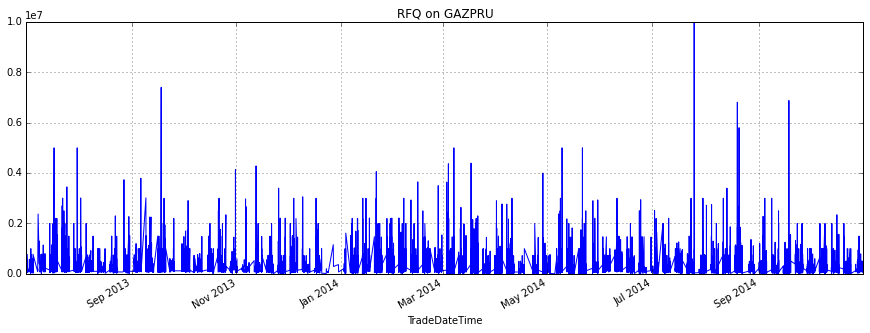

In [3]:
df['NotionalEUR'].plot(figsize=(15,5), title = 'RFQ on GAZPRU')

In [4]:
from hawkes.hawkes import GetTimeSeriesFromCSV, ExpectationMaximization, Q

In [5]:
time = GetTimeSeriesFromCSV('GAZPRU.csv', nbpoints=1000)

In [6]:
def inspect(verbose=False):
    it = [0]
    QQ = []
    def inspectclosed(mu, a, b, t, p, dt, T, S0, S1, S2):
        it[0] += 1
        q = Q(mu, a, b, t, p, dt)
        QQ.append(q)
        if it[0] == 1 or it[0] % 10 == 0:
            print ("iter = %s: (mu, a, b) = (%.2f, %.2f, %.2f)" % (it[0], mu, a, b)).ljust(35),
            print "Q = %s" % q
    inspectclosed.QQ = QQ
    return inspectclosed
        
inspector = inspect(verbose=False)
ExpectationMaximization(time, niter=100, callback=inspector)

iter = 1: (mu, a, b) = (8.48, 3.87, 2.68) Q = -215.30546722
iter = 10: (mu, a, b) = (114.52, 11.82, 12.44) Q = 1187.10291105
iter = 20: (mu, a, b) = (195.67, 22.70, 27.22) Q = 2372.21377461
iter = 30: (mu, a, b) = (159.41, 131.12, 153.27) Q = 3847.94887433
iter = 40: (mu, a, b) = (137.47, 1562.35, 1802.20) Q = 6170.80975432
iter = 50: (mu, a, b) = (188.92, 2507.70, 3080.53) Q = 7008.15405309
iter = 60: (mu, a, b) = (193.44, 2567.31, 3171.64) Q = 7064.38975136
iter = 70: (mu, a, b) = (193.72, 2570.99, 3177.33) Q = 7067.90606326
iter = 80: (mu, a, b) = (193.74, 2571.22, 3177.69) Q = 7068.12543357
iter = 90: (mu, a, b) = (193.74, 2571.23, 3177.71) Q = 7068.13911801
iter = 100: (mu, a, b) = (193.74, 2571.23, 3177.71) Q = 7068.13997165


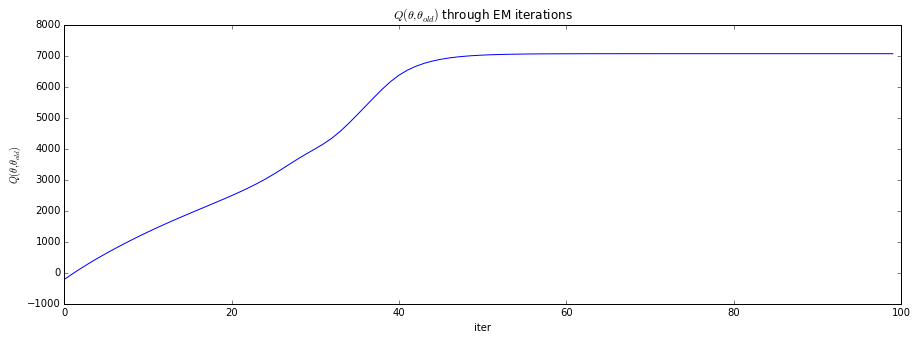

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(inspector.QQ)
plt.title(r"$Q(\theta, \theta_{old})$ through EM iterations")
plt.xlabel(r"iter")
plt.ylabel(r"$Q(\theta, \theta_{old})$")
plt.show()

## Create GAZPRU.csv

In [3]:
df = pd.read_csv('/Users/arnaud/cellule/data/bnpp/ETSAnonymousPricesFull.csv', parse_dates=['TradeDateTime'], index_col='TradeDateTime')

/Users/arnaud/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (9,53) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [9]:
df2 = df[df["BuySell"] == "Buy"]
df3 = df2[df2["Ticker"] == "GAZPRU"]

In [11]:
df3.to_csv("GAZPRU.csv")